# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

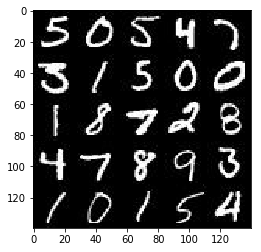

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

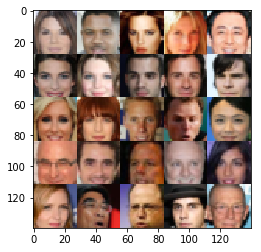

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)



        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse= not (is_train)):

        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha=0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
   
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                
                #Random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                #Print loss every 10 steps
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                #Show images every 100 steps
                if steps % 100 == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2690... Generator Loss: 1.9502
Epoch 1/2... Discriminator Loss: 0.2398... Generator Loss: 1.8744
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 12.2160
Epoch 1/2... Discriminator Loss: 0.1483... Generator Loss: 2.4184
Epoch 1/2... Discriminator Loss: 0.0364... Generator Loss: 7.3867
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 1.1775
Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 0.3010... Generator Loss: 2.9122
Epoch 1/2... Discriminator Loss: 0.0428... Generator Loss: 4.4564
Epoch 1/2... Discriminator Loss: 0.2631... Generator Loss: 4.5089


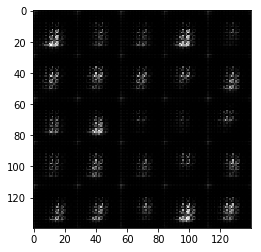

Epoch 1/2... Discriminator Loss: 0.2689... Generator Loss: 2.7148
Epoch 1/2... Discriminator Loss: 0.1458... Generator Loss: 3.1928
Epoch 1/2... Discriminator Loss: 0.1285... Generator Loss: 2.9670
Epoch 1/2... Discriminator Loss: 0.1804... Generator Loss: 2.7127
Epoch 1/2... Discriminator Loss: 2.9422... Generator Loss: 0.1749
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 2.8783
Epoch 1/2... Discriminator Loss: 0.6657... Generator Loss: 2.9084
Epoch 1/2... Discriminator Loss: 0.4852... Generator Loss: 3.4918
Epoch 1/2... Discriminator Loss: 0.3193... Generator Loss: 2.4201
Epoch 1/2... Discriminator Loss: 0.4001... Generator Loss: 3.8010


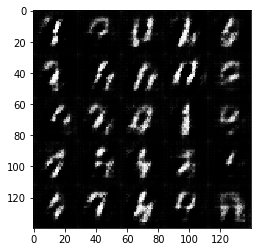

Epoch 1/2... Discriminator Loss: 0.5009... Generator Loss: 1.9265
Epoch 1/2... Discriminator Loss: 0.7212... Generator Loss: 1.4948
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 1.8754
Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 3.0297
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 2.1950
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 1.0595
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 1.8369
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 2.5046
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 0.6391


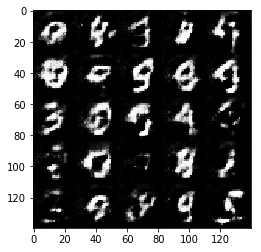

Epoch 1/2... Discriminator Loss: 0.9429... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 1.2532
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.8294
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 1.2216
Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.5089
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 1.8631
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 2.0221
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 0.9489


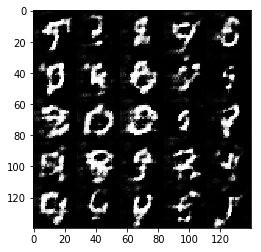

Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.1255
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.5122
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 1.4171
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 2.3827
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.1018
Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 1.5473
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 1.1604


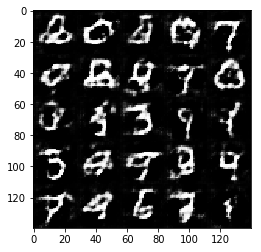

Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 0.8628
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.4086
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 0.6570
Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.6500
Epoch 2/2... Discriminator Loss: 0.7574... Generator Loss: 1.8719
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 2.4914
Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.5924
Epoch 2/2... Discriminator Loss: 0.7835... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 0.6179


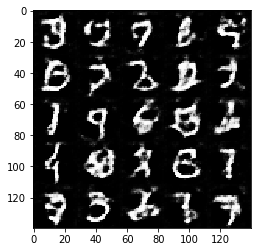

Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.3976
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.0514
Epoch 2/2... Discriminator Loss: 0.9076... Generator Loss: 1.6362
Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.5937... Generator Loss: 3.0648
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.6509
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 1.4959
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.6279


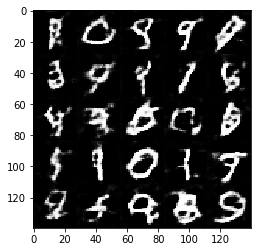

Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.2072
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.4573
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.6058
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 0.4767
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 1.1403
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.8144... Generator Loss: 1.3373


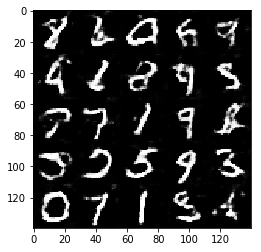

Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 2.4147
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.5429
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 1.6464
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.0325... Generator Loss: 0.5951
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 1.0935


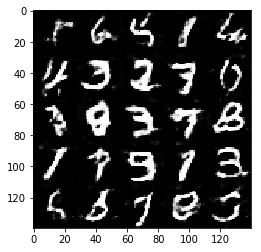

Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 1.2612
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.0685


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2401... Generator Loss: 5.2061
Epoch 1/1... Discriminator Loss: 0.2496... Generator Loss: 10.2042
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 11.5227
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.2471
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.9819
Epoch 1/1... Discriminator Loss: 2.0588... Generator Loss: 0.1797
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 2.4669


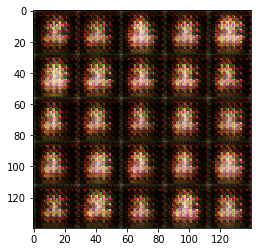

Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 1.3818
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 1.9319
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 2.0023
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 4.0267
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.3697
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.1736


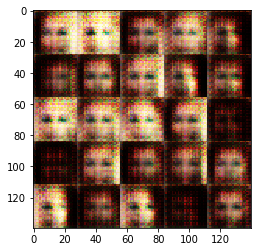

Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.5737
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 2.5311
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.3915
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7522


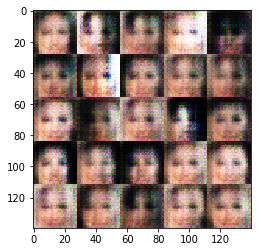

Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 3.2239
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 2.2103
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.5920
Epoch 1/1... Discriminator Loss: 1.8867... Generator Loss: 2.3334
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.4061


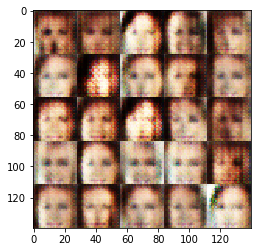

Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 1.9374


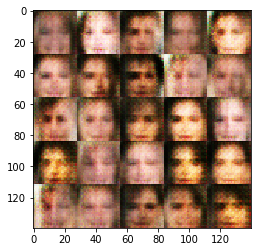

Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.3795
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.7199
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.6136
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 1.7247


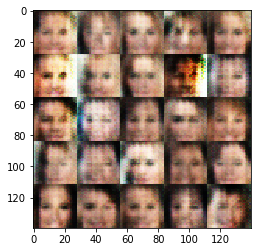

Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.8417
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.8442
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.0784


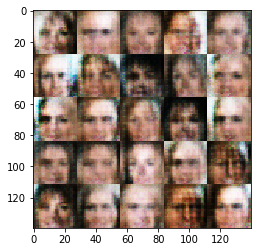

Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.3053


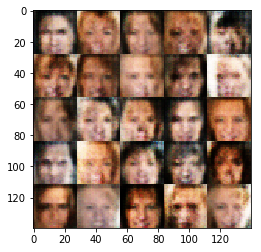

Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.2390
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 2.1001
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.0065


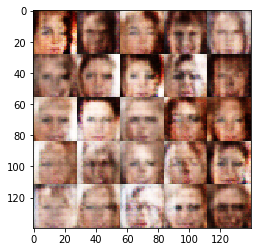

Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.9024
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.3336


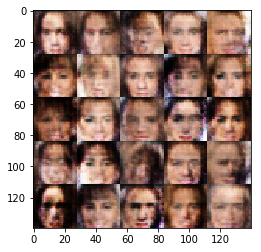

Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.3085
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 0.8892


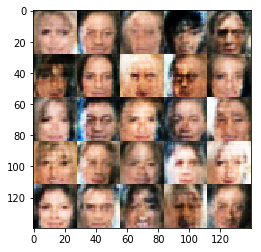

Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7799


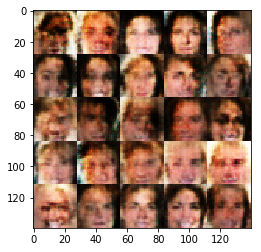

Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.5531
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.5040
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.0190


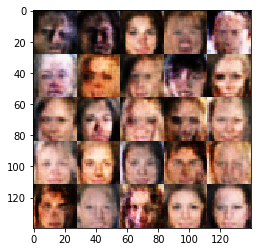

Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.3348
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.8737


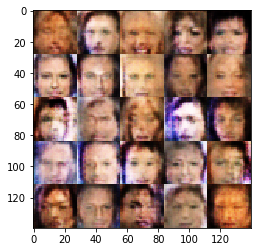

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9964


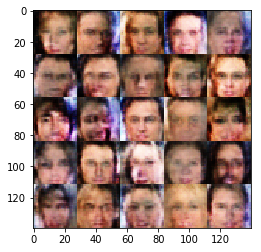

Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.7931
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.4552
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.8268
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.6393


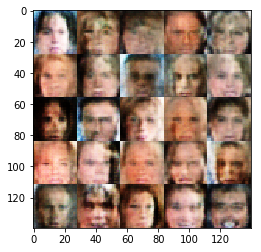

Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.0955


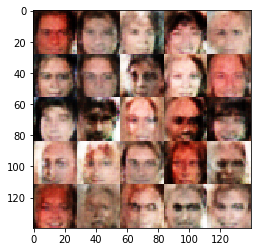

Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.5557
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 0.8823


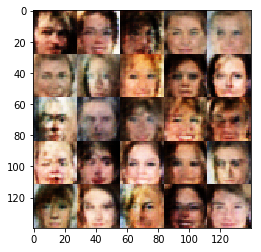

Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.6853


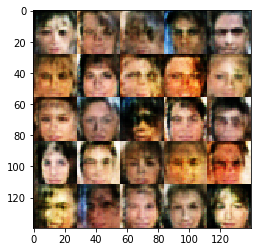

Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.2676


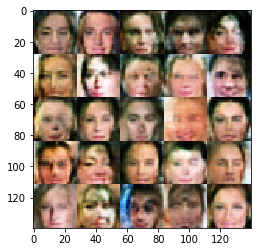

Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.6853


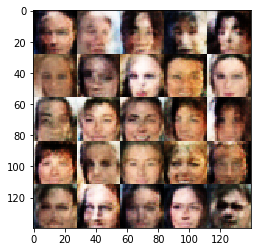

Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.5825
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.4499
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.4854
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 1.8230... Generator Loss: 0.2717
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.2607


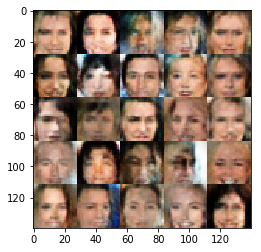

Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.6400
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5480


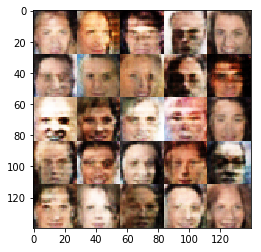

Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 2.3477
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 1.5858
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.4053


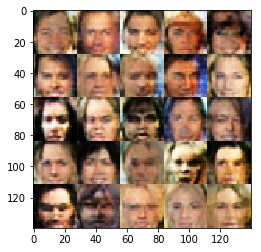

Epoch 1/1... Discriminator Loss: 1.9055... Generator Loss: 2.0761
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 1.7188
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.6914
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 1.6575
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.3270
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.3282
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.9163


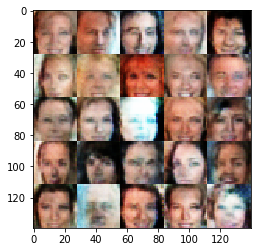

Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.4019
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 2.2333


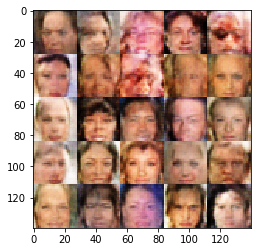

Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.3747
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.8099


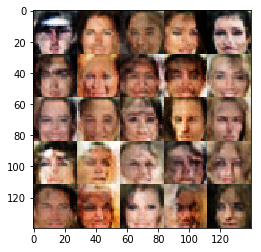

Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.7057
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.6914
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.7132
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.9176


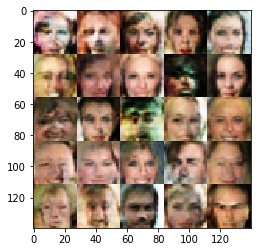

Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.3503
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 1.9312
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.0040


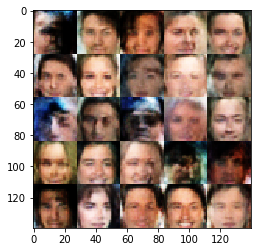

Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.6481
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.9415
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.3968


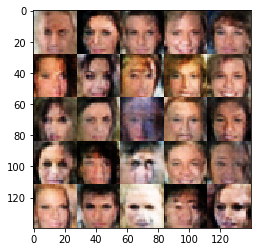

Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 1.5127
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8518


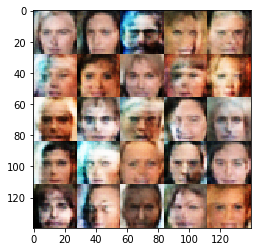

Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.3911


In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.